In [1]:
import torch
from torchvision import transforms, datasets

In [2]:
from typing import Any, Callable, cast, Dict, List, Optional, Tuple
class AnalDataset(datasets.ImageFolder):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path, target = self.samples[index]
        path = path.replace("\\", "/")
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return path, (sample, target)    

In [3]:
PATH_TO_DATASET = 'dataset/jpg/MNIST - JPG - testing/'
MEAN, STD = [0.1307], [0.3081]
dataset = AnalDataset(root=PATH_TO_DATASET, 
                      transform=transforms.Compose([
                          transforms.Grayscale(num_output_channels=1), 
                          transforms.ToTensor(), 
                          transforms.Normalize(mean=MEAN, std=STD)]))
print(f"Length {len(dataset)}")

Length 10000


path='dataset/jpg/MNIST - JPG - testing/1/1189.jpg'; target=1; shape=torch.Size([1, 28, 28])


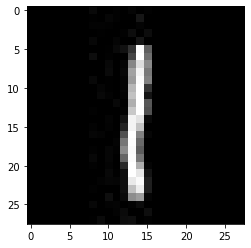

In [4]:
import matplotlib.pyplot as plt
path, (tensor_image, target) = dataset[1001]
plt.imshow(  tensor_image.permute(1, 2, 0), cmap="gray")
print(f"{path=}; {target=}; shape={tensor_image.shape}" )

In [5]:
BATCH_SIZE = 100
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
PATH_TO_MODEL = 'anal-model-jit-script.pth'
model = torch.jit.load(PATH_TO_MODEL)
model.cuda()
model.eval()
pass

In [7]:
from tqdm import tqdm
wrongs = []
rights = []
images = {}
with torch.no_grad():
    for paths, (tensor_images, targets) in tqdm(dataloader, desc="Checking images", unit="batchs",leave=True):
        tensor_images, targets = tensor_images.cuda(), targets.cuda()
        logits = model(tensor_images)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predictions = torch.max(probabilities, dim=1)[1]
        mask = predictions.eq(targets)
        
        wrong_indexes = torch.where(mask == False)[0]
        right_indexes = torch.where(mask == True)[0]
        for wrong_index in wrong_indexes:
            wrong_path = paths[wrong_index]
            wrong_pred = predictions[wrong_index].item()
            true = targets[wrong_index].item()
            wrongs.append((wrong_path, wrong_pred, true))
            images.update({wrong_path: tensor_images[wrong_index]})
        
        for right_index in right_indexes:
            right_path = paths[right_index]
            right_pred = predictions[right_index].item()
            rights.append((right_path, right_pred))
            images.update({right_path: tensor_images[right_index]})

Checking images:   0%|                                                                     | 0/100 [00:00<?, ?batchs/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
Checking images: 100%|███████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.23batchs/s]


In [8]:
import random as r
print(f"+--TRUE-+-FALSE-+\n|  {len(rights)} |  {len(wrongs)}  |\n|-------+-------|\n|   {len(images)} all   |\n+---------------+\n")
wrong_example = r.choice(wrongs)
right_example = r.choice(rights)
print(f"wrong example: {wrong_example};\nright example: {right_example};")

+--TRUE-+-FALSE-+
|  9892 |  108  |
|-------+-------|
|   10000 all   |
+---------------+

wrong example: ('dataset/jpg/MNIST - JPG - testing/8/8408.jpg', 5, 8);
right example: ('dataset/jpg/MNIST - JPG - testing/0/3818.jpg', 0);


In [9]:
right_sample = r.sample(rights, 995)
wrong_sample = r.sample(wrongs, 5)

In [10]:
import os
import glob
PATH_TO_OUTPUT  = "MNIST_test_data/"

if os.path.exists(PATH_TO_OUTPUT):
    print("Каталог существует. Очищаем...")
    files = glob.glob(PATH_TO_OUTPUT+'*')
    for f in files:
        os.remove(f)
else:
    print("Каталог не существует. Создаём...")
    os.mkdir(PATH_TO_OUTPUT)
    
for target_num in range(10):
    current_path = os.path.join(PATH_TO_OUTPUT, str(target_num))
    os.mkdir(current_path)

Каталог не существует. Создаём...


In [11]:
import textwrap
flag ="YetiCTF{i_hate_these_dataset_anomalies}" 
separate = lambda string: textwrap.wrap(string, (len(string)//len(wrong_sample) + 1))
partition = separate(flag)

In [12]:
from exif import Image
for index, wrong in enumerate(wrong_sample):
    path, prediction, target = wrong
    with open(path, "rb") as unpredictable:
        image = Image(unpredictable)
        if image.has_exif: 
            image.delete_all() 
        image.set("image_description", f"({index + 1}/{len(partition)}):{partition[index]}")
    mark = path.rpartition("/")[-1]
    path_to_save = f"{PATH_TO_OUTPUT}/{target}/{mark}"
    with open(path_to_save, 'wb') as saving_file:
        saving_file.write(image.get_file())

In [13]:
import string
for index, right in enumerate(right_sample):
    path, target = right
    with open(path, "rb") as predictable:
        image = Image(predictable)
        if image.has_exif: 
            image.delete_all() 
        random_value = ''.join([r.choice(string.ascii_letters + string.digits) for n in range(16)])
        image.set("image_description", f"({(index % len(partition) + 1)}/{len(partition)}):{random_value}")
    mark = path.rpartition("/")[-1]
    path_to_save = f"{PATH_TO_OUTPUT}/{target}/{mark}"
    with open(path_to_save, 'wb') as saving_file:
        saving_file.write(image.get_file())

In [14]:
import shutil
shutil.make_archive(PATH_TO_OUTPUT, 'zip', PATH_TO_OUTPUT)

'D:\\MyCodes\\Projects\\YetiCTF\\MNISTED - Not tested\\dev\\MNIST_test_data.zip'